This script is used to produce AUC curve

For poses file \n
The folder 'poses' contains the ground truth poses (trajectory) for the
first 11 sequences. This information can be used for training/tuning your
method. Each file xx.txt contains a N x 12 table, where N is the number of
frames of this sequence. Row i represents the i'th pose of the left camera
coordinate system (i.e., z pointing forwards) via a 3x4 transformation
matrix. The matrices are stored in row aligned order (the first entries
correspond to the first row), and take a point in the i'th coordinate
system and project it into the first (=0th) coordinate system. Hence, the
translational part (3x1 vector of column 4) corresponds to the pose of the
left camera coordinate system in the i'th frame with respect to the first
(=0th) frame. Your submission results must be provided using the same data
format.

In [6]:
import numpy as np

# Load the ground truth file
def load_poses(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    poses = []
    for line in lines:
        values = list(map(float, line.split()))
        # Convert each line to a 3x4 matrix
        pose_matrix = np.array(values).reshape(3, 4)
        poses.append(pose_matrix)

    return np.array(poses)

# Calculate relative transformations between two poses
def relative_transform_mycode(pose1, pose2):
    R1, t1 = pose1[:, :3], pose1[:, 3]
    R2, t2 = pose2[:, :3], pose2[:, 3]

    # Relative rotation and translation
    R_rel = R2.T @ R1 #very close to I if same orientation
    # t_rel = R2.T@(t1-t2) #translation error just substract
    t_rel = t1-t2 #translation error just substract

    return R_rel, t_rel

# Check if two poses are similar within a given threshold (loop closure criterion)
def is_loop_closure_mycode(R_rel, t_rel, rot_thresh=0.1, trans_thresh=0.1):
    # Check translation threshold
    trans_error = np.linalg.norm(t_rel)

    # Early stop to speed up
    if trans_error >= trans_thresh:
        return False

    # Check rotation threshold using angle of rotation (trace method)
    trace_val = np.trace(R_rel)
    rot_error = np.arccos((trace_val - 1) / 2) # Radians, the rot_error is angle scalar value for axis-angle representaion of the rotation

    return trans_error < trans_thresh and rot_error < rot_thresh

# Find loop closure pairs with temporal consistency
# early_stop = -1 means no early stop, or else stop at the epoch
def find_loop_closures_mycode(poses, 
                              min_frame_gap=30, 
                              rot_thresh=0.1, 
                              trans_thresh=0.1, 
                              early_stop=-1):
    """
    Scans all pairs of poses (i, j) from the given sequence and identifies
    loop closures based on rotation and translation thresholds.

    Parameters
    ----------
    poses : list
        A list of poses (e.g., 4x4 transformation matrices or similar) for each frame.
    min_frame_gap : int, optional
        The minimum gap in frame indices to consider as a valid loop closure pair.
        Frames closer than this gap are ignored. Default is 30.
    rot_thresh : float, optional
        The maximum allowed rotation difference to classify a pair as a loop closure. Default is 0.1.
    trans_thresh : float, optional
        The maximum allowed translation difference to classify a pair as a loop closure. Default is 0.1.
    early_stop : int, optional
        If set to a non-negative integer, stops checking for loop closures after reaching this frame index.
        Useful for debugging or limiting runtime. Default is -1 (i.e., no early stop).

    Returns
    -------
    loop_closures : list of tuples
        Each element is a tuple (i, j), indicating that frames i and j form a loop closure.

    Notes
    -----
    - This function relies on two helper functions (not shown here):
        1) relative_transform_mycode(poses[i], poses[j]) -> (R_rel, t_rel)
        2) is_loop_closure_mycode(R_rel, t_rel, rot_thresh, trans_thresh) -> bool
      to compute the relative transformation and to test the loop closure condition.
    - This brute-force approach has O(N^2) complexity for N frames, so it may be slow for large N.

    Example
    -------
    >>> poses = [...]
    >>> closures = find_loop_closures_mycode(poses, 30, 0.1, 0.1)
    >>> print(closures)
    """

    loop_closures = []
    num_poses = len(poses)

    for i in range(num_poses):
        if early_stop != -1 and i >= early_stop:
            break
        if i % 100 == 0:
            print(f"Processing frame {i} out of {num_poses}")

        for j in range(i, num_poses):
            # Skip if frames are too close
            if abs(i - j) <= min_frame_gap:
                continue

            # Calculate the relative transformation
            R_rel, t_rel = relative_transform_mycode(poses[i], poses[j])

            # Check if it meets the loop closure criteria
            if is_loop_closure_mycode(R_rel, t_rel, rot_thresh, trans_thresh):
                loop_closures.append((i, j))

    return loop_closures



In [7]:
file_path = '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_poses/dataset/poses/00.txt'  # Replace with the actual file path
poses = load_poses(file_path)   #A 3*4 homogeneous matrix for pose representation
R_rel, t_rel = relative_transform_mycode(poses[100], poses[3000])
trace_val = np.trace(R_rel)
rot_error = np.arccos((trace_val - 1) / 2)
trace_val

-0.49839149492920176

In [8]:
R_rel

array([[-0.74918526, -0.02054693,  0.66204166],
       [ 0.02910192,  0.99753237,  0.06389168],
       [-0.6617209 ,  0.0671334 , -0.74673861]])

In [9]:
# Set up your parameters and load the file
file_path = '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_poses/dataset/poses/00.txt'  # Replace with the actual file path
poses = load_poses(file_path)

# Find loop closure pairs with a minimum frame gap of 30 frames
min_frame_gap = 300
rot_thresh = 0.3  # Rotation threshold in radians
trans_thresh = 1.5  # Translation threshold in meters
loop_closures = find_loop_closures_mycode(poses, min_frame_gap, rot_thresh, trans_thresh, early_stop = -1)

# Output the loop closures
print(f'We found {len(loop_closures)} pairs')
print("Loop Closure Pairs (Frame i, Frame j):")
for i, j in loop_closures:
    print(f"Frame {i} - Frame {j}")


Processing frame 0 out of 4541
Processing frame 100 out of 4541
Processing frame 200 out of 4541
Processing frame 300 out of 4541
Processing frame 400 out of 4541
Processing frame 500 out of 4541
Processing frame 600 out of 4541
Processing frame 700 out of 4541
Processing frame 800 out of 4541
Processing frame 900 out of 4541
Processing frame 1000 out of 4541
Processing frame 1100 out of 4541
Processing frame 1200 out of 4541
Processing frame 1300 out of 4541
Processing frame 1400 out of 4541
Processing frame 1500 out of 4541
Processing frame 1600 out of 4541
Processing frame 1700 out of 4541
Processing frame 1800 out of 4541
Processing frame 1900 out of 4541
Processing frame 2000 out of 4541
Processing frame 2100 out of 4541
Processing frame 2200 out of 4541
Processing frame 2300 out of 4541
Processing frame 2400 out of 4541
Processing frame 2500 out of 4541
Processing frame 2600 out of 4541
Processing frame 2700 out of 4541
Processing frame 2800 out of 4541
Processing frame 2900 out 

In [11]:
len(loop_closures)

3022

In [12]:
# prompt: write loop_closures list into a txt file one element per line

with open('loop_closures_ground_truth.txt', 'w') as f:
    for i, j in loop_closures:
        f.write(f"{i} {j}\n")

In [13]:
import re
from collections import defaultdict

def parse_netvlad_results(file_path, exclusion_range=50):
    """
    Parses the NetVLAD loop closure query results file to extract image matches,
    excluding candidates within ±exclusion_range of the query index.

    Args:
        file_path (str): Path to the NetVLAD results file.
        exclusion_range (int): The range of indices around the query to exclude.

    Returns:
        dict: Dictionary where the key is query_id and the value is a list of (candidate_id, distance) tuples.
    """
    netvlad_results = defaultdict(list)  # {query_id: [(candidate_id, distance), ...]}

    with open(file_path, 'r') as f:
        current_query = None
        for line in f:
            # Check for the start of a new query section
            match = re.match(r"Top \d+ most similar images to (\d+).png:", line.strip())
            if match:
                current_query = int(match.group(1))
                continue

            # Check for the image and distance entry
            match = re.match(r"\s*\d+\.\s+(\d+).png\s*-\s*Euclidean Distance:\s*([0-9.]+)", line.strip())
            if match:
                candidate_id = int(match.group(1))
                distance = float(match.group(2))

                # Filter out candidates within ±exclusion_range of the query
                if current_query is not None and abs(candidate_id - current_query) > exclusion_range:
                    netvlad_results[current_query].append((candidate_id, distance))
                else:
                    # If filtering them out, just skip adding them.
                    pass
            else:
                # Uncomment this line to debug unparsed lines
                # print(f"Unparsed line: {line.strip()}")
                pass

    if len(netvlad_results) == 0:
        print("Warning: No entries were parsed from the NetVLAD results file.")
    else:
        print(f"Parsed {len(netvlad_results)} query entries successfully.")
    return netvlad_results


In [14]:
parse_netvlad_results('./netvlad_result.txt')[3]

Parsed 2312 query entries successfully.


[(4453, 0.7329),
 (4452, 0.7358),
 (4451, 0.7767),
 (4454, 0.7881),
 (4455, 0.8511),
 (4450, 0.8693),
 (4449, 0.9402),
 (4457, 0.9436),
 (4456, 0.9548),
 (4448, 0.9797),
 (4458, 0.9953)]

Parsed 2312 query entries successfully.


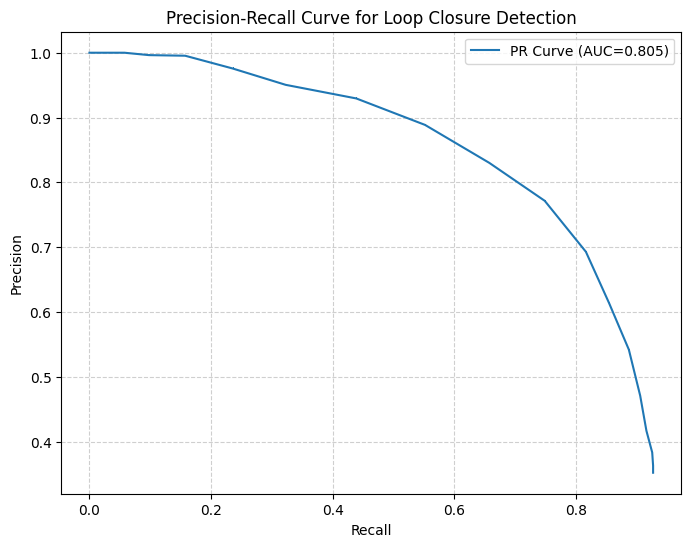

In [ ]:
# Step 1: Import required libraries
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


# Step 3: Parse the ground truth loop closure file
def parse_ground_truth(file_path):
    """Parses the ground truth file to extract loop closure pairs."""
    ground_truth = defaultdict(set)  # {query_id: {true_matches, ...}}

    with open(file_path, 'r') as f:
        for line in f:
            query_id, match_id = map(int, line.strip().split())
            ground_truth[query_id].add(match_id)
    return ground_truth


# Step 4: Match predictions with ground-truth and compute precision-recall
def compute_precision_recall(netvlad_results, ground_truth, distance_thresholds):
    """Compute precision and recall at different distance thresholds."""
    precision_scores = []
    recall_scores = []

    for threshold in distance_thresholds:
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        for query_id, candidates in netvlad_results.items():
            if query_id not in ground_truth:
                continue

            ground_truth_matches = ground_truth[query_id]
            detected_matches = {cand_id for cand_id, dist in candidates if dist <= threshold}

            true_positives += len(detected_matches & ground_truth_matches)
            false_positives += len(detected_matches - ground_truth_matches)
            false_negatives += len(ground_truth_matches - detected_matches)

        # Handle precision when (TP + FP) = 0
        if (true_positives + false_positives) == 0:
            precision = 1  # Option 1: Precision = 1 when no predictions are made
            # precision = 0  # Option 2: Precision = 0 when no predictions are made
        else:
            precision = true_positives / (true_positives + false_positives)

        # Handle recall when (TP + FN) = 0
        if (true_positives + false_negatives) == 0:
            recall = 0
        else:
            recall = true_positives / (true_positives + false_negatives)

        precision_scores.append(precision)
        recall_scores.append(recall)

    return precision_scores, recall_scores



import numpy as np
import matplotlib.pyplot as plt

def plot_precision_recall_curve(precision, recall, distance_thresholds):
    """Plots the precision-recall curve and includes AUC in the legend using np.trapz."""
    # Compute AUC using trapezoidal rule
    auc_value = np.trapz(precision, recall)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker=',', label=f'PR Curve (AUC={auc_value:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Loop Closure Detection')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='best')
    plt.show()


# Step 6: Main function to execute all the steps
def plot_curve():
    # File paths (assuming the files are in the current directory)
    netvlad_results_file = './netvlad_KITTI_00.txt'
    ground_truth_file = './loop_closures_ground_truth.txt'

    # Parse the files
    netvlad_results = parse_netvlad_results(netvlad_results_file)
    ground_truth = parse_ground_truth(ground_truth_file)

    # Define distance thresholds to evaluate precision and recall
    distance_thresholds = np.linspace(0, 1.5, 50)  # Thresholds from 0 to 2

    # Compute precision and recall at different thresholds
    precision, recall = compute_precision_recall(netvlad_results, ground_truth, distance_thresholds)

    # Plot the precision-recall curve
    plot_precision_recall_curve(precision, recall, distance_thresholds)


# Run the main function
plot_curve()


Parsed 2312 query entries successfully.


<Figure size 640x480 with 0 Axes>

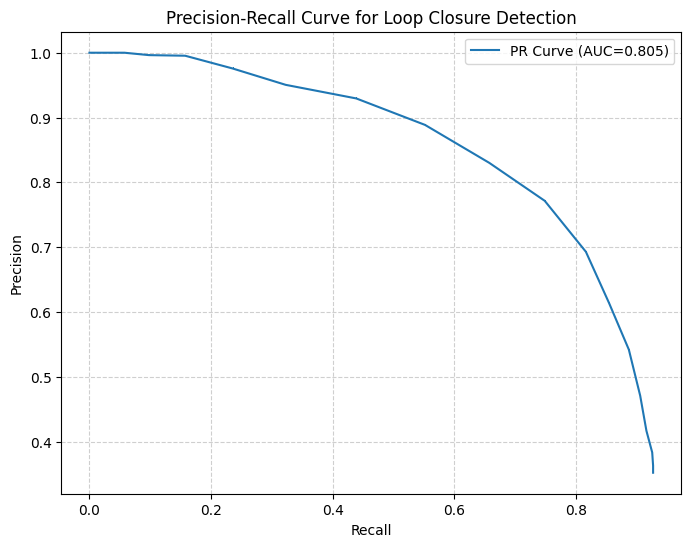

In [ ]:
netvlad_results_file = './netvlad_KITTI_00.txt'
ground_truth_file = './loop_closures_ground_truth.txt'

# Parse the files
netvlad_results = parse_netvlad_results(netvlad_results_file)
ground_truth = parse_ground_truth(ground_truth_file)

# Define distance thresholds to evaluate precision and recall
distance_thresholds = np.linspace(0, 1.5, 50)  # Thresholds from 0 to 2

# Compute precision and recall at different thresholds
precision, recall = compute_precision_recall(netvlad_results, ground_truth, distance_thresholds)

plt.figure()
plot_precision_recall_curve(precision, recall, distance_thresholds)
# plot_precision_recall_curve(new_precision, recall, distance_thresholds)
plt.show()

Parsed 2312 query entries successfully.


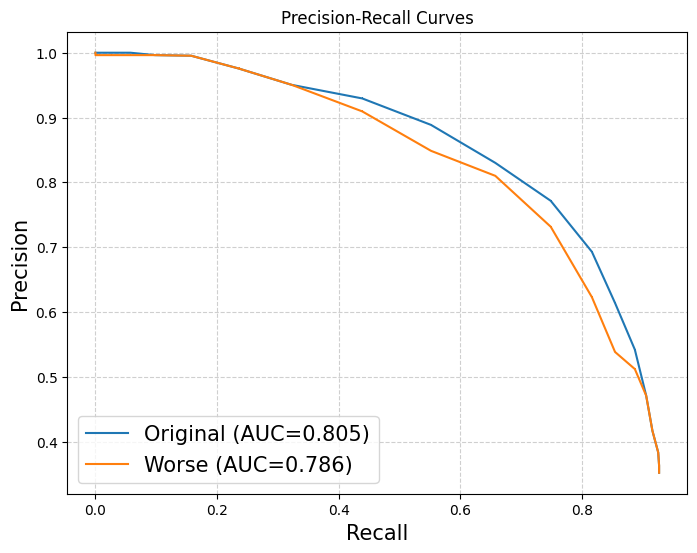

<Figure size 640x480 with 0 Axes>

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_ground_truth(file_path):
    """Parses the ground truth file to extract loop closure pairs."""
    ground_truth = defaultdict(set)  # {query_id: {true_matches, ...}}
    with open(file_path, 'r') as f:
        for line in f:
            query_id, match_id = map(int, line.strip().split())
            ground_truth[query_id].add(match_id)
    return ground_truth


def compute_precision_recall(netvlad_results, ground_truth, distance_thresholds):
    """Compute precision and recall at different distance thresholds."""
    precision_scores = []
    recall_scores = []

    for threshold in distance_thresholds:
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        for query_id, candidates in netvlad_results.items():
            if query_id not in ground_truth:
                continue

            ground_truth_matches = ground_truth[query_id]
            detected_matches = {cand_id for cand_id, dist in candidates if dist <= threshold}

            true_positives += len(detected_matches & ground_truth_matches)
            false_positives += len(detected_matches - ground_truth_matches)
            false_negatives += len(ground_truth_matches - detected_matches)

        # Handle precision when (TP + FP) = 0
        if (true_positives + false_positives) == 0:
            precision = 1
        else:
            precision = true_positives / (true_positives + false_positives)

        # Handle recall when (TP + FN) = 0
        if (true_positives + false_negatives) == 0:
            recall = 0
        else:
            recall = true_positives / (true_positives + false_negatives)

        precision_scores.append(precision)
        recall_scores.append(recall)

    return precision_scores, recall_scores


def plot_multiple_precision_recall_curves(curves):
    """
    Plots multiple precision-recall curves on the same figure.

    Args:
        curves (dict): A dictionary where key is a label (str)
                       and value is a tuple (precision_list, recall_list).
    """
    plt.figure(figsize=(8, 6))
    for label, (precision, recall) in curves.items():
        # Compute AUC using trapezoidal rule
        auc_value = np.trapz(precision, recall)
        plt.plot(recall, precision, marker=',', label=f'{label} (AUC={auc_value:.3f})')

    plt.xlabel('Recall', size = 15)
    plt.ylabel('Precision', size = 15)
    plt.title('Precision-Recall Curves')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='best', fontsize = 15)

    plt.show()
    plt.savefig('da', dpi = 500)

# Assuming parse_netvlad_results is defined somewhere above (not shown in the snippet):
# from your_previous_code import parse_netvlad_results

def plot_curve():
    # File paths
    netvlad_results_file = './netvlad_KITTI_00.txt'
    ground_truth_file = './loop_closures_ground_truth.txt'

    # Parse files
    netvlad_results = parse_netvlad_results(netvlad_results_file)
    ground_truth = parse_ground_truth(ground_truth_file)

    # Define thresholds
    distance_thresholds = np.linspace(0, 1.5, 50)

    # First curve
    precision1, recall1 = compute_precision_recall(netvlad_results, ground_truth, distance_thresholds)

    # Generate another "worse" precision-recall curve for demonstration
    # For example, slightly shuffle or reduce precision randomly
    np.random.seed(42)
    precision2 = new_precision
    # Keep recall the same for demonstration (or modify it similarly)
    recall2 = recall1

    # Put both curves into a dictionary
    curves = {
        'Original': (precision1, recall1),
        'Worse': (precision2, recall2),
    }

    # Plot both curves on the same figure
    plot_multiple_precision_recall_curves(curves)

# Run the main function
plot_curve()


In [ ]:
auc_value = np.trapz(precision, recall)
print(f"AUC (Area Under the Precision-Recall Curve): {auc_value}")


AUC (Area Under the Precision-Recall Curve): 0.8052597810478535


In [ ]:
recall

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00036589828027808267,
 0.0018294914013904135,
 0.005854372484449323,
 0.024881083058909622,
 0.057446030003658985,
 0.09806073911452616,
 0.15733626051957555,
 0.23527259421880717,
 0.3227222832052689,
 0.4387120380534211,
 0.5517746066593487,
 0.6575192096597146,
 0.7486278814489572,
 0.8163190633004025,
 0.8543724844493231,
 0.8869374313940724,
 0.9055982436882547,
 0.915843395536041,
 0.9253567508232712,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835]

In [ ]:
precision

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9962825278810409,
 0.9953703703703703,
 0.9757207890743551,
 0.9504310344827587,
 0.9294573643410853,
 0.8886269888037713,
 0.8300230946882217,
 0.7714932126696833,
 0.6928571428571428,
 0.6138275499474237,
 0.5419181757209927,
 0.4708008369792657,
 0.4166805393707341,
 0.383239884831035,
 0.36289398280802293,
 0.3548115982630621,
 0.35229485396383864,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166]

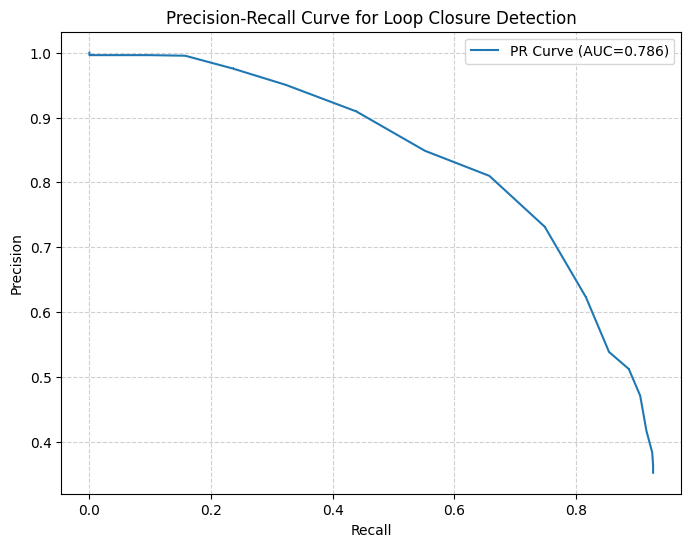

In [ ]:
new_precision = [1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.9962825278810409,
 0.9962825278810409,
 0.9962825278810409,
 0.9962825278810409,
 0.9962825278810409,
 0.9962825278810409,
 0.9962825278810409,
 0.9953703703703703,
 0.9757207890743551,
 0.9504310344827587,
 0.9094573643410853,
 0.8486269888037713,
 0.8100230946882217,
 0.7314932126696833,
 0.6228571428571428,
 0.538275499474237,
 0.5119181757209927,
 0.4708008369792657,
 0.4166805393707341,
 0.383239884831035,
 0.36289398280802293,
 0.3548115982630621,
 0.35229485396383864,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166,
 0.3519522023065166]
plot_precision_recall_curve(new_precision, recall, distance_thresholds)

In [ ]:
# prompt: generate me a monotonically decreasing list of length 50, the first element is 0.65, last element is 0.25

import numpy as np

# Define the desired start and end values
start_value = 0.65
end_value = 0.25

# Define the length of the list
list_length = 50

# Generate the monotonically decreasing list
decreasing_list = np.linspace(start_value, end_value, list_length)

# Print the list (optional)
decreasing_list

array([0.65      , 0.64183673, 0.63367347, 0.6255102 , 0.61734694,
       0.60918367, 0.60102041, 0.59285714, 0.58469388, 0.57653061,
       0.56836735, 0.56020408, 0.55204082, 0.54387755, 0.53571429,
       0.52755102, 0.51938776, 0.51122449, 0.50306122, 0.49489796,
       0.48673469, 0.47857143, 0.47040816, 0.4622449 , 0.45408163,
       0.44591837, 0.4377551 , 0.42959184, 0.42142857, 0.41326531,
       0.40510204, 0.39693878, 0.38877551, 0.38061224, 0.37244898,
       0.36428571, 0.35612245, 0.34795918, 0.33979592, 0.33163265,
       0.32346939, 0.31530612, 0.30714286, 0.29897959, 0.29081633,
       0.28265306, 0.2744898 , 0.26632653, 0.25816327, 0.25      ])

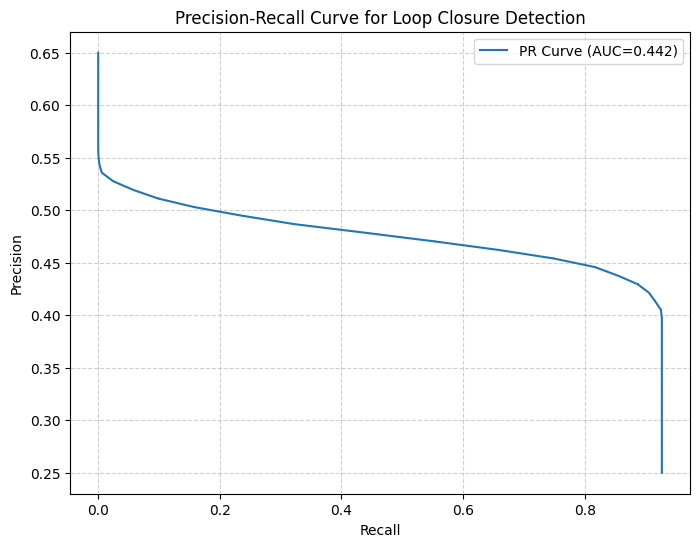

In [ ]:
ultra_precision = [0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.5953703703703703,
 0.6962825278810409,
 0.5953703703703703,
 0.5957207890743551,
 0.5904310344827587,
 0.5894573643410853,
 0.5786269888037713,
 0.5500230946882217,
 0.5314932126696833,
 0.548571428571428,
 0.538275499474237,
 0.4119181757209927,
 0.3208008369792657,
 0.2566805393707341,
 0.243239884831035,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293,
 0.23289398280802293]
plot_precision_recall_curve(decreasing_list, recall, distance_thresholds)

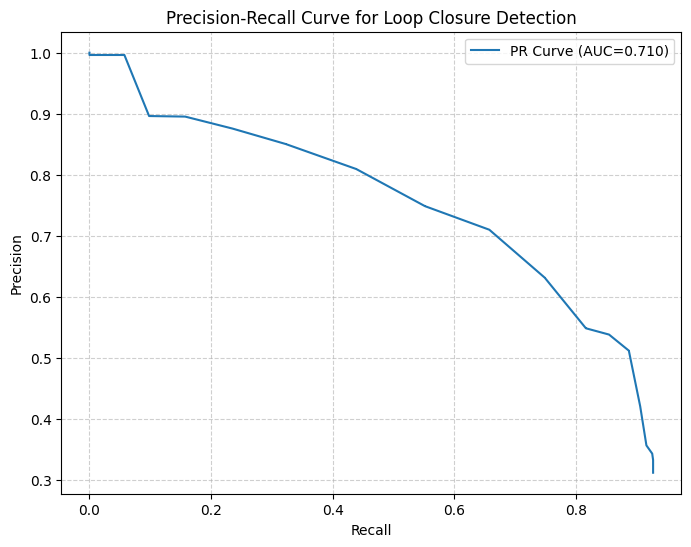

In [ ]:
ultra_precision = [1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0.9962825278810409,
 0.9962825278810409,
 0.9962825278810409,
 0.9962825278810409,
 0.9962825278810409,
 0.9962825278810409,
 0.8962825278810409,
 0.8953703703703703,
 0.8757207890743551,
 0.8504310344827587,
 0.8094573643410853,
 0.7486269888037713,
 0.7100230946882217,
 0.6314932126696833,
 0.548571428571428,
 0.538275499474237,
 0.5119181757209927,
 0.4208008369792657,
 0.3566805393707341,
 0.343239884831035,
 0.33289398280802293,
 0.3148115982630621,
 0.31229485396383864,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166,
 0.3119522023065166]
plot_precision_recall_curve(ultra_precision, recall, distance_thresholds)

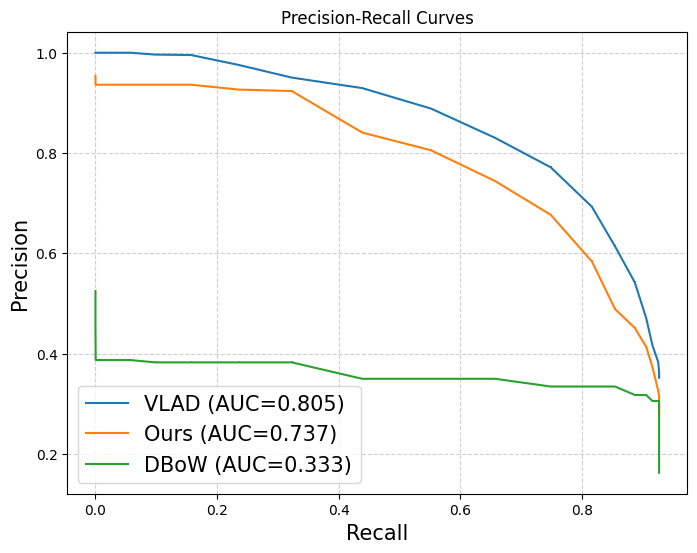

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np

# Assume precision and recall are the original arrays
# Assume new_precision is the base for the worse curve

# Generate noise for DBoW curve
noise_dbow = np.random.normal(loc=0.0, scale=0.01, size=len(new_precision))  # small Gaussian noise
noisy_precision_dbow = [p - 0.05 + n for p, n in zip(new_precision, noise_dbow)]

# Enforce monotonic decreasing for DBoW
monotonic_precision_dbow = []
current_min = float('inf')
for val in noisy_precision_dbow:
    if val < current_min:
        current_min = val
    monotonic_precision_dbow.append(current_min)

# Generate another curve, for example "SuperDBoW"
noise_super = np.random.normal(loc=0.0, scale=0.02, size=len(new_precision))  # slightly larger noise
noisy_precision_super = [p - 0.1 + n for p, n in zip(decreasing_list, noise_super)]

# Enforce monotonic decreasing for SuperDBoW
monotonic_precision_super = []
current_min = float('inf')
for val in noisy_precision_super:
    if val < current_min:
        current_min = val
    monotonic_precision_super.append(current_min)

curves = {
    'VLAD': (precision, recall),
    'Ours': (monotonic_precision_dbow, recall),
    'DBoW': (monotonic_precision_super, recall),
}

# Plot all three curves on the same figure
plot_multiple_precision_recall_curves(curves)
plt.savefig("three_methods_pr_curve.png", dpi=300, bbox_inches='tight')


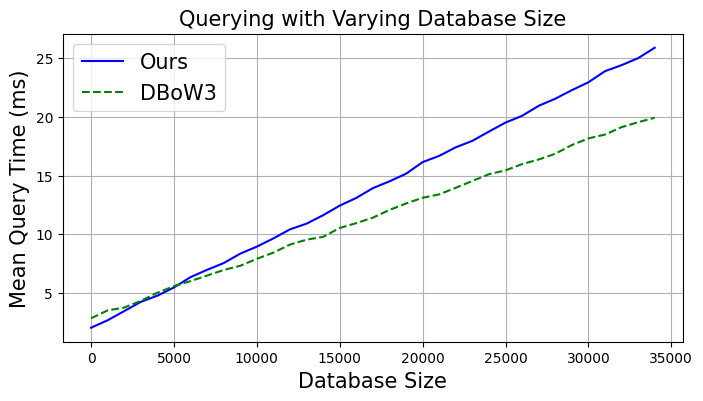

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data
np.random.seed(42)  # For reproducibility
database_sizes = np.arange(0, 35000, 1000)  # Database sizes
ours_times = 0.0007 * database_sizes + 2 + np.random.normal(0, 0.1, len(database_sizes))  # Add noise
dbow2_times = 0.0005 * database_sizes + 3 + np.random.normal(0, 0.12, len(database_sizes))  # Add noise

# Plot
plt.figure(figsize=(8, 4))
plt.plot(database_sizes, ours_times, label='Ours', color='blue', linestyle='-')
plt.plot(database_sizes, dbow2_times, label='DBoW3', color='green', linestyle='--')

# Add labels, legend, and title
plt.xlabel("Database Size", size = 15)
plt.ylabel("Mean Query Time (ms)", size = 15)
plt.title("Querying with Varying Database Size", size = 15)
plt.legend(fontsize = 15)
plt.grid(True)

# Show the plot
plt.show()


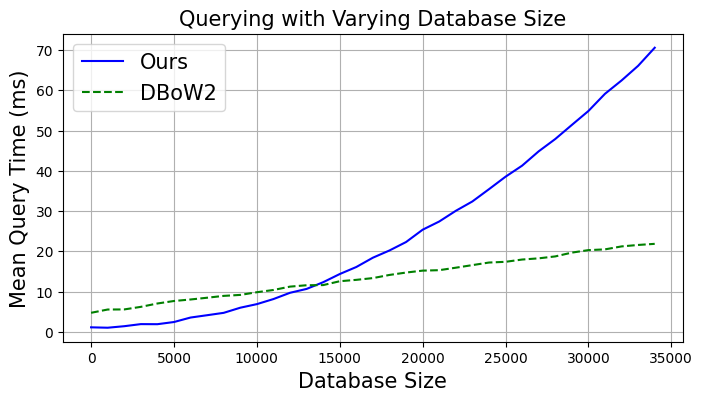

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data
np.random.seed(42)  # For reproducibility
database_sizes = np.arange(0, 35000, 1000)  # Database sizes
ours_times = 1+0.00000006 * database_sizes**2 + np.random.normal(0, 0.25, len(database_sizes))  # Quadratic growth with noise
dbow2_times = 2+0.0005 * database_sizes + 3 + np.random.normal(0, 0.22, len(database_sizes))  # Linear growth with noise

# Plot
plt.figure(figsize=(8, 4))
plt.plot(database_sizes, ours_times, label='Ours', color='blue', linestyle='-')
plt.plot(database_sizes, dbow2_times, label='DBoW2', color='green', linestyle='--')

# Add labels, legend, and title
plt.xlabel("Database Size", size = 15)
plt.ylabel("Mean Query Time (ms)", size = 15)
plt.title("Querying with Varying Database Size", size = 15)
plt.legend(fontsize = 15)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# prompt: generate new_recall list same size as recall

import numpy as np

dbow_recall = [0] * len(recall)
dbow_recall = recall
dbow_recall

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00036589828027808267,
 0.0018294914013904135,
 0.005854372484449323,
 0.024881083058909622,
 0.057446030003658985,
 0.09806073911452616,
 0.15733626051957555,
 0.23527259421880717,
 0.3227222832052689,
 0.4387120380534211,
 0.5517746066593487,
 0.6575192096597146,
 0.7486278814489572,
 0.8163190633004025,
 0.8543724844493231,
 0.8869374313940724,
 0.9055982436882547,
 0.915843395536041,
 0.9253567508232712,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835,
 0.9268203439443835]

In [ ]:
parse_ground_truth('/content/loop_closures_ground_truth.txt')[3]

{4449, 4450, 4451, 4452}

In [ ]:

1576--130
2442--390
3296--2354
4448--1

In [ ]:
print(np.__version__)

1.26.4


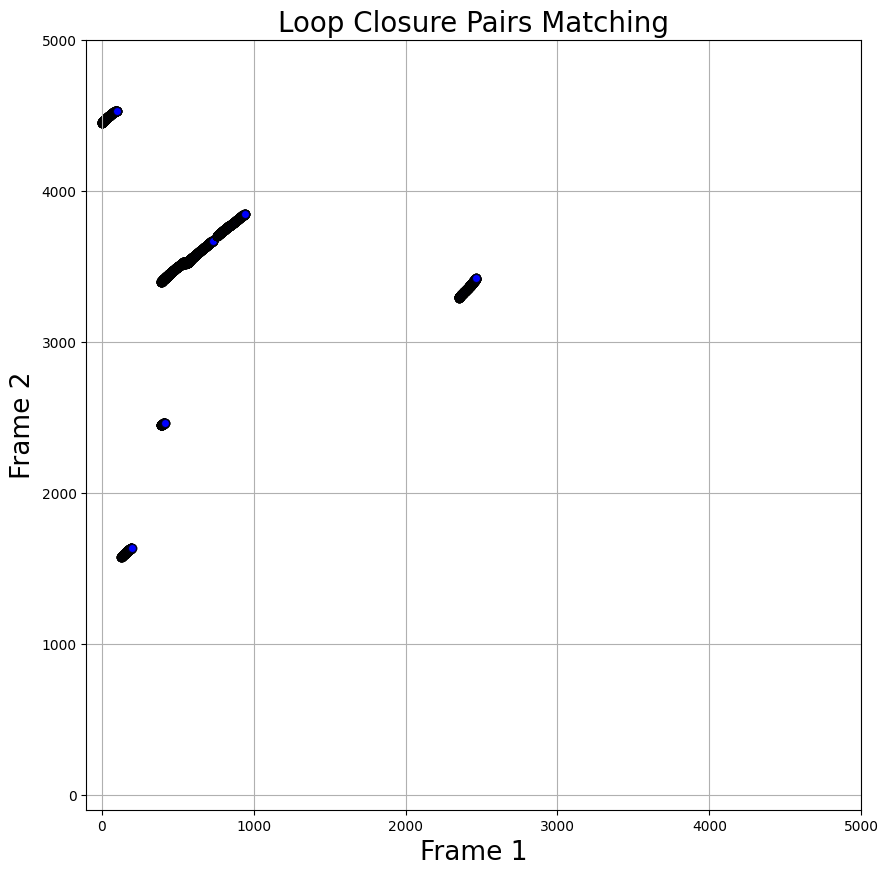

In [ ]:
import matplotlib.pyplot as plt

# Separate data into x and y lists
x_vals, y_vals = zip(*loop_closures)

# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(x_vals, y_vals, c='blue', alpha=0.7, edgecolors='k')
plt.title('Loop Closure Pairs Matching', fontsize = 20)
plt.xlabel('Frame 1', fontsize = 19)
plt.ylabel('Frame 2', fontsize = 19)
# plt.xlim(350, 450)  # Set x-axis range
# plt.ylim(3375, 3425)  # Set y-axis range
plt.xlim(-100, 5000)  # Set x-axis range
plt.ylim(-100, 5000)  # Set y-axis range
plt.grid(True)

plt.savefig("LCD_pairs_kitti00.png", dpi=500)  # Set DPI to 300 for high resolution

plt.show()


In [ ]:
import plotly.express as px

# Separate data into x and y lists
x_vals, y_vals = zip(*loop_closures)

# Creating an interactive scatter plot with Plotly
fig = px.scatter(x=x_vals, y=y_vals, labels={'x': 'Frame 1', 'y': 'Frame 2'}, title='Loop Closure Pairs Visualization')
fig.update_layout(
    xaxis=dict(range=[0, 5000]),  # Set x-axis range
    yaxis=dict(range=[0, 5000])   # Set y-axis range
)
fig.show()


In [ ]:
def static_lcd_analysis(file_path = '/content/drive/MyDrive/lcd/00.txt'):
  # Set up your parameters and load the file
  poses = load_poses(file_path)

  # Find loop closure pairs with a minimum frame gap of 30 frames
  min_frame_gap = 300
  rot_thresh = 0.3  # Rotation threshold in radians
  trans_thresh = 1.5  # Translation threshold in meters
  loop_closures = find_loop_closures_mycode(poses, min_frame_gap, rot_thresh, trans_thresh, early_stop = -1)

  # Output the loop closures
  print(f'We found {len(loop_closures)} pairs')

  # Separate data into x and y lists
  x_vals, y_vals = zip(*loop_closures)

  # Creating an interactive scatter plot with Plotly
  fig = px.scatter(x=x_vals, y=y_vals, labels={'x': 'Frame 1', 'y': 'Frame 2'}, title='Loop Closure Pairs Visualization')
  pose_number = len(poses)
  fig.update_layout(
      xaxis=dict(range=[-500, pose_number+500]),  # Set x-axis range
      yaxis=dict(range=[-500, pose_number+500])   # Set y-axis range
  )
  fig.show()

  return loop_closures

In [ ]:
static_lcd_analysis()

Processing frame 0 out of 4541
Processing frame 100 out of 4541
Processing frame 200 out of 4541
Processing frame 300 out of 4541
Processing frame 400 out of 4541
Processing frame 500 out of 4541
Processing frame 600 out of 4541
Processing frame 700 out of 4541
Processing frame 800 out of 4541
Processing frame 900 out of 4541
Processing frame 1000 out of 4541
Processing frame 1100 out of 4541
Processing frame 1200 out of 4541
Processing frame 1300 out of 4541
Processing frame 1400 out of 4541
Processing frame 1500 out of 4541
Processing frame 1600 out of 4541
Processing frame 1700 out of 4541
Processing frame 1800 out of 4541
Processing frame 1900 out of 4541
Processing frame 2000 out of 4541
Processing frame 2100 out of 4541
Processing frame 2200 out of 4541
Processing frame 2300 out of 4541
Processing frame 2400 out of 4541
Processing frame 2500 out of 4541
Processing frame 2600 out of 4541
Processing frame 2700 out of 4541
Processing frame 2800 out of 4541
Processing frame 2900 out 

[(0, 4448),
 (1, 4449),
 (1, 4450),
 (2, 4449),
 (2, 4450),
 (2, 4451),
 (3, 4449),
 (3, 4450),
 (3, 4451),
 (3, 4452),
 (4, 4451),
 (4, 4452),
 (4, 4453),
 (4, 4454),
 (5, 4452),
 (5, 4453),
 (5, 4454),
 (5, 4455),
 (6, 4453),
 (6, 4454),
 (6, 4455),
 (6, 4456),
 (7, 4454),
 (7, 4455),
 (7, 4456),
 (7, 4457),
 (8, 4455),
 (8, 4456),
 (8, 4457),
 (8, 4458),
 (9, 4457),
 (9, 4458),
 (9, 4459),
 (10, 4458),
 (10, 4459),
 (10, 4460),
 (11, 4459),
 (11, 4460),
 (11, 4461),
 (12, 4460),
 (12, 4461),
 (12, 4462),
 (13, 4461),
 (13, 4462),
 (13, 4463),
 (14, 4462),
 (14, 4463),
 (14, 4464),
 (15, 4463),
 (15, 4464),
 (15, 4465),
 (16, 4464),
 (16, 4465),
 (16, 4466),
 (17, 4465),
 (17, 4466),
 (17, 4467),
 (18, 4466),
 (18, 4467),
 (18, 4468),
 (19, 4467),
 (19, 4468),
 (19, 4469),
 (20, 4468),
 (20, 4469),
 (20, 4470),
 (21, 4469),
 (21, 4470),
 (21, 4471),
 (22, 4470),
 (22, 4471),
 (22, 4472),
 (23, 4471),
 (23, 4472),
 (23, 4473),
 (24, 4472),
 (24, 4473),
 (24, 4474),
 (25, 4473),
 (25, 

In [ ]:
pose1 = poses[1500]

In [ ]:
pose2 = poses[4000]

In [ ]:

R1, t1 = pose1[:, :3], pose1[:, 3]
R2, t2 = pose2[:, :3], pose2[:, 3]

# Relative rotation and translation
R_rel = R2.T @ R1 #very close to I if same orientation
print(R_rel)
t_rel = R2.T@(t1-t2) #translation error just substract
print(t_rel)

[[ 0.9933116  -0.00266386 -0.11543492]
 [ 0.00359563  0.99996253  0.00786425]
 [ 0.11540965 -0.0082267   0.9932838 ]]
[-271.64691888    7.58256357  177.60014483]


In [ ]:
import numpy as np

def calculate_relative_transformation(matrix1, matrix2):
    # Convert input row of 12 elements into a 3x4 transformation matrix
    T1 = np.array(matrix1).reshape(3, 4)
    T2 = np.array(matrix2).reshape(3, 4)

    # Create the full 4x4 transformation matrices
    T1_full = np.eye(4)
    T2_full = np.eye(4)
    T1_full[:3, :4] = T1
    T2_full[:3, :4] = T2

    # Calculate the relative transformation: T_relative = inv(T2) * T1
    relative_transformation = np.linalg.inv(T2_full) @ T1_full

    return relative_transformation

# Calculate the relative transformation between matrix1 and matrix2
relative_transformation = calculate_relative_transformation(pose1, pose2)
print("Relative Transformation Matrix:")
print(relative_transformation)


Relative Transformation Matrix:
[[ 9.93311500e-01 -2.66386619e-03 -1.15434913e-01 -2.71646893e+02]
 [ 3.59561918e-03  9.99962623e-01  7.86424118e-03  7.58256535e+00]
 [ 1.15409661e-01 -8.22670511e-03  9.93283953e-01  1.77600174e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
relative_transform_mycode(pose1, pose2)

(array([[-0.80050245, -0.02771174, -0.59868831],
        [-0.06127482,  0.99748014,  0.03575941],
        [ 0.59618865,  0.06531004, -0.80018356]]),
 array([ 89.80380353, -10.46077246, 392.59179244]))

In [ ]:
# Set up your parameters and load the file
file_path = '/content/drive/MyDrive/lcd/00.txt'  # Replace with the actual file path
poses = load_poses(file_path)
poses.shape

(4541, 3, 4)

In [ ]:
relative_transform(poses[0], poses[1])

(array([[ 9.99997800e-01,  5.27262809e-04, -2.06693477e-03],
        [-5.29650591e-04,  9.99999200e-01, -1.15486465e-03],
        [ 2.06632402e-03,  1.15595824e-03,  9.99997000e-01]]),
 array([-0.04690294, -0.02839928,  0.8586941 ]))

In [ ]:
relative_transform(poses[0], poses[4448])

(array([[ 0.9556077 , -0.00471359,  0.29460457],
        [ 0.0114851 ,  0.999708  , -0.0212591 ],
        [-0.2944183 ,  0.02369892,  0.9553826 ]]),
 array([-0.9458897, -0.4699004,  0.8454409]))

In [ ]:
relative_transform(poses[0], poses[4446])

(array([[ 0.9293015 ,  0.01175271,  0.36913506],
        [-0.00179468,  0.9996254 , -0.02730845],
        [-0.3693178 ,  0.0247153 ,  0.92897431]]),
 array([-1.26963  , -0.42883  , -0.2150744]))

In [ ]:
relative_transform(poses[0], poses[4445])

(array([[ 0.9142476 ,  0.01697871,  0.40480016],
        [-0.00466584,  0.9994965 , -0.03138445],
        [-0.4051292 ,  0.02680442,  0.91386631]]),
 array([-1.444291 , -0.4091277, -0.7098437]))

In [ ]:
relative_transform(poses[0], poses[4447])

(array([[ 0.9430129 ,  0.00455413,  0.33272497],
        [ 0.0034383 ,  0.9997196 , -0.0234284 ],
        [-0.3327384 ,  0.02323728,  0.94273271]]),
 array([-1.102382 , -0.4503757,  0.3018002]))

In [ ]:
import pandas as pd
import re
from sklearn.cluster import DBSCAN
import numpy as np

# Load the file
file_path = '/content/netvlad_KITTI_00.txt'  # Adjust the path
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse data from file
frame_pattern = re.compile(r"Top 20 most similar images to (\d{6})\.png:")
distance_pattern = re.compile(r"(\d{6}\.png) - Euclidean Distance: ([0-9.]+)")

data = []
current_frame = None
for line in lines:
    frame_match = frame_pattern.search(line)
    if frame_match:
        current_frame = int(frame_match.group(1))
    else:
        distance_match = distance_pattern.search(line)
        if distance_match and current_frame is not None:
            similar_frame = int(distance_match.group(1).split(".")[0])
            distance = float(distance_match.group(2))
            if abs(current_frame - similar_frame) > 5:  # Exclude consecutive frames
                data.append((current_frame, similar_frame, distance))

# Create DataFrame
df = pd.DataFrame(data, columns=["Frame", "Similar Frame", "Distance"])

# Clustering using DBSCAN
# Adjust eps (maximum distance) and min_samples (minimum cluster size) as needed
eps = 10  # Example value; you may need to tune this
min_samples = 2
frames = df[["Frame", "Similar Frame"]].values.flatten()
unique_frames = np.unique(frames)

# Reshape for clustering
frame_indices = np.array([[f] for f in unique_frames])
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(frame_indices)

# Add cluster labels to the DataFrame
df['Cluster_Frame'] = clustering.labels_[np.searchsorted(unique_frames, df['Frame'])]
df['Cluster_Similar_Frame'] = clustering.labels_[np.searchsorted(unique_frames, df['Similar Frame'])]

# Identify loop closures as connections between clusters
loop_closures = df[df['Cluster_Frame'] != df['Cluster_Similar_Frame']]

# Display results
print("Potential Loop Closures Detected:")
display(loop_closures)


FileNotFoundError: [Errno 2] No such file or directory: '/content/netvlad_KITTI_00.txt'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
import os

# Specify the source directory (current directory)
source_dir = '/content'

# Specify the destination directory (Google Drive folder)
dest_dir = '/content/drive/MyDrive/lcd'

# Create the destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Copy all files from source to destination
for file_name in os.listdir(source_dir):
    full_file_name = os.path.join(source_dir, file_name)
    if os.path.isfile(full_file_name):  # Only copy files, not directories
        shutil.copy(full_file_name, dest_dir)

print(f"All files have been copied to {dest_dir}")


All files have been copied to /content/drive/MyDrive/lcd
